# Reading the ROOT files

In [1]:
exec(open("./do_imports.py").read())

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

2.3.0 /home/sophiafarrell/.local/lib/python3.7/site-packages/tensorflow/__init__.py


In [2]:
from evaluate_results import *

We want where quicknext<500 us (so another prompt follows) and the subid==1. 

What if we boost our fast-neutron stamps by not requiring it to be the first event (so tri-neutron events recorded too but in pairs?) 
<br>
Obviously this is not realistic since we'd veto these by having 3, but we can at least pretend they're di-neutrons! 

Edit: the next code is already doing that! We gain 1149/5500 of the stats from that trick, which is necessary. 

In [3]:
def get_paired_data(data):
    next_ts = data.timestamp[1:]
    next_ts = ak.concatenate([next_ts, 0])

    condition_1 = next_ts - data.timestamp<600
    condition_2 = next_ts - data.timestamp>0
    condition_3 = data.dt_next_us < 600

    both = condition_1 * condition_2 * condition_3

    first_of_two = ak.where(both)[0]
    signal1 = data[first_of_two]
    signal2 = data[first_of_two+1]
    
    return signal1, signal2

In [4]:
fn0, fn1 = get_paired_data(fastn)
ibd0, ibd1 = get_paired_data(ibd)

### Prep data for model input

In [5]:
selection = [ibd0, fn0]
samples = min([len(i) for i in selection])
# smth = [i[:samples] for i in selection]

npmts = 2330
timetot = 1500 #ns 
tres = 10 # ns 
div_factor = tres 
nbins = int(timetot/tres)


In [6]:
size = samples * len(selection)
y = np.array([]) 

first = np.zeros((size, npmts, nbins), dtype=np.float32)
second = np.zeros_like(first)

data_to_manipulate = [[fn0, fn1], [ibd0, ibd1]]
for d, (signal1, signal2) in enumerate(data_to_manipulate):
    print('set %i of %i'%(d+1, len(data_to_manipulate)))
    
    new_bins1 = ak.values_astype((signal1.hittime-300)/div_factor, np.int32)
    new_bins2 = ak.values_astype((signal2.hittime-300)/div_factor, np.int32)

#     for i in range(0, samples):
#         first[(d+1)*i, signal1.channel[i], new_bins1[i]]=signal1.pmtcharge[i]
#         second[(d+1)*i, signal2.channel[i], new_bins2[i]]=signal2.pmtcharge[i]
    y=np.append(y, d*np.ones(samples))


set 1 of 2
set 2 of 2


In [7]:
X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(
    first, second, y,
    test_size=0.25, random_state=43
)
del first, second, data_to_manipulate, new_bins1, new_bins2,
gc.collect()

60

------

Separate out prompt/delayed IBD and delta-ray/neutron capture fast-neutrons

## Getting data in input form

Need to get those with a 1 for sure as it has a 0, then take those separated by the 0 or 1 

In [8]:
#Shortcut to grab some old calculated outputs
rnn_out_test = np.loadtxt("testpreds.csv", delimiter=",", ndmin=2)
rnn_out_train = np.loadtxt("trainpreds.csv", delimiter=",", ndmin=2)

In [9]:
model = load_model('weights/coupled_crnn_2.h5')
model.summary()

In [11]:
rnn_out_test = model.predict([X_test1, X_test2], verbose=1)

89/89 [==============================] - 135s 2s/step


In [13]:
rnn_out_train = model.predict([X_train1, X_train2], verbose=1)
np.savetxt("testpreds.csv", rnn_out_test, delimiter=",")
np.savetxt("trainpreds.csv", rnn_out_train, delimiter=",")

del model
gc.collect()

267/267 [==============================] - 405s 2s/step


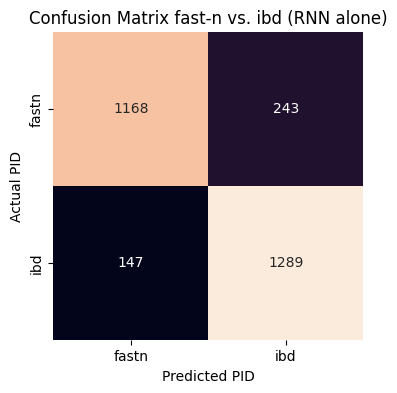

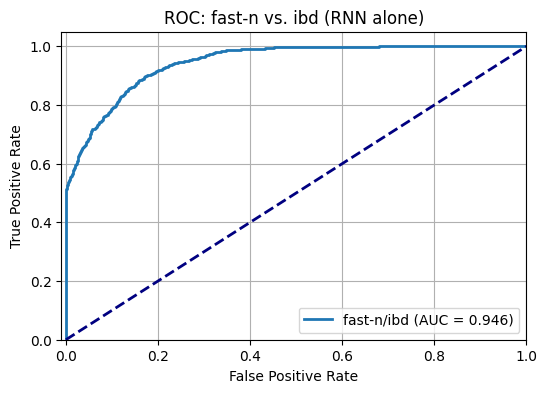

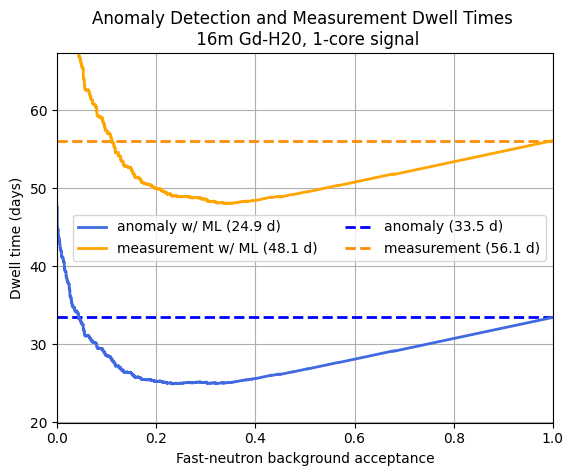

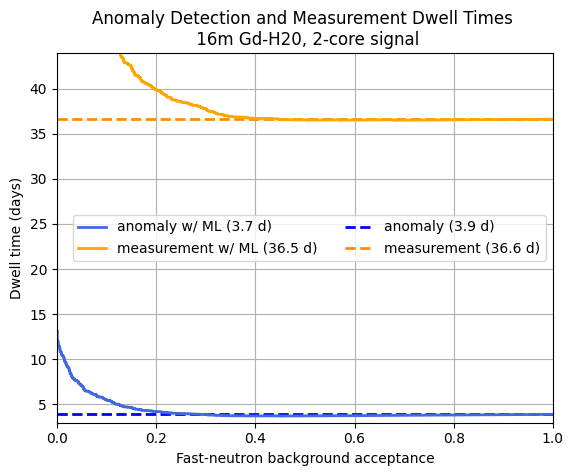

In [9]:
ml = ML_Evaluation(y_test, rnn_out_test)
ml.draw_confmat(extra_title='(RNN alone)')
tpr, fpr, thresholds = ml.draw_roc(extra_title='(RNN alone)')

acceptances = dict(fpr=fpr, tpr=tpr)
quick_analysis(acceptances)

## Take RNN output and add to X1 (RF) data

In [10]:
def rnn_to_rf(X_train, X_test, 
              y_train, y_test, 
              add_rnn=True, classes=2,
             ):
    dims_add = dimensions.copy()
    newdims = ['rnn_out']

    if classes>2:
        y_train = np.argmax(y_train, axis=1)
        y_test = np.argmax(y_test, axis=1)
        newdims = ['rnn_out_fn', 'rnn_out_ibd0', 'rnn_out_ibd1']
    if not add_rnn: 
        return X_train, X_test, y_train, y_test, dims_add
    
    new_train = np.hstack((X_train, rnn_out_train))
    new_test = np.hstack((X_test, rnn_out_test))
    
    for i in newdims:
        dims_add.append(i)    
    return new_train, new_test, y_train, y_test, dims_add

In [11]:
dimensions = [
    'n9', 'n100', 
#     'x', 'y', 'z', 'r',
    'id_plus_dr_hit', 
    'good_dir', 
#     'good_dir_next', 'good_pos_next', 
    'good_pos',
    'closestPMT', #  'closestPMT_next', 'distpmt', 
    'drNextr', # 'dzNextz', 
     'dt_next_us', 
#     'azimuth_ks', 'azimuth_ks_next',
#     'n100_next','n9_next',
    'pe', 
    'beta_one', 'beta_four',
#     'beta_one', 'beta_two', 'beta_three', 'beta_four', 'beta_five', 'beta_six',
#     'beta_one_prev', 'beta_two_prev', 'beta_three_prev', 'beta_four_prev', 'beta_five_prev', 'beta_six_prev',
]

In [12]:
data_to_manipulate = [fn0, ibd0]
samples = min([len(i) for i in data_to_manipulate])

x1 = data_to_manipulate[0][:samples]
x1 = ak.concatenate((x1, data_to_manipulate[1][:samples]))

X1 = get_dims(x1, dimensions=dimensions)
X1 = ak.to_pandas(X1)

X_train3, X_test3, y_train, y_test= train_test_split(X1, y, test_size=0.25, random_state=43) 
X_save = X_test3
sc = StandardScaler()
X_train3 = sc.fit_transform(X_train3)
X_test3 = sc.transform(X_test3)

Remaining variables selected for analysis: 11


In [13]:
new_train, new_test, yy_train, yy_test, dims_add = rnn_to_rf(X_train3, X_test3, y_train, y_test)

In [14]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(
    n_estimators=100, 
    max_depth=12, 
#     min_samples_leaf=2,
    bootstrap=True,
)
#Train the model using the training sets
clf.fit(new_train,yy_train)
feature_imp = pd.Series(clf.feature_importances_,index=dims_add).sort_values(ascending=False)

In [15]:
y_train_pred = clf.predict(new_train)
y_test_pred=clf.predict(new_test)
scores = clf.predict_proba(new_test)

In [16]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(yy_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(yy_test, y_test_pred)*100))

Train Accuracy: 99.02%
Test Accuracy: 94.56%


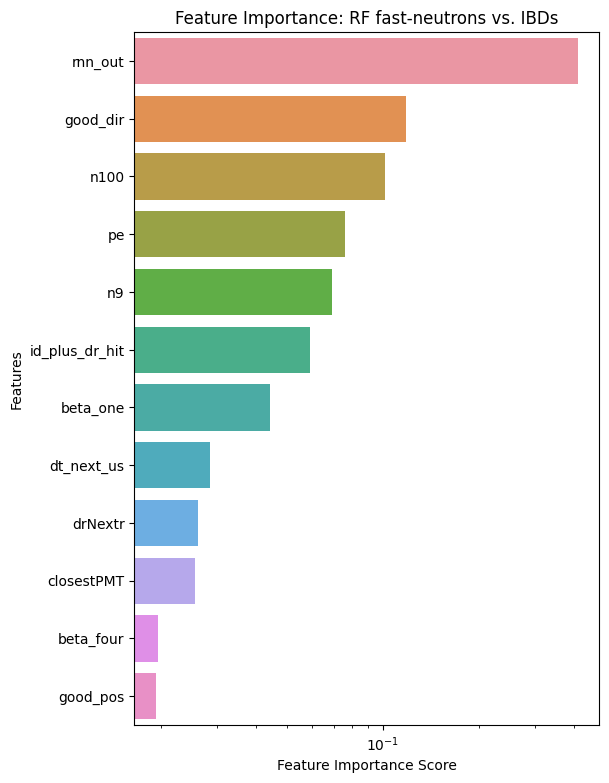

In [17]:
# Creating a bar plot
plt.figure(figsize=(6, 9))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF fast-neutrons vs. IBDs")
plt.show()

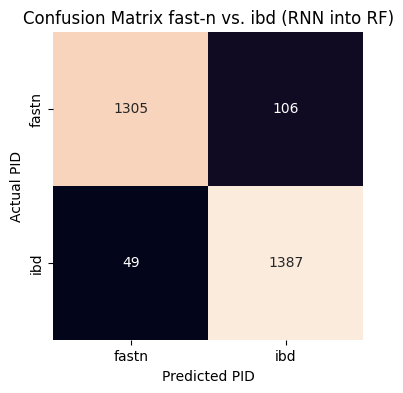

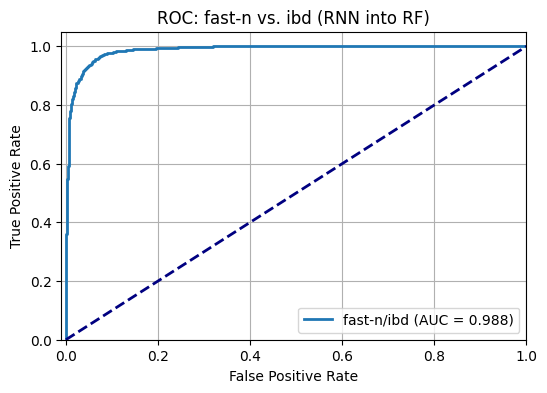

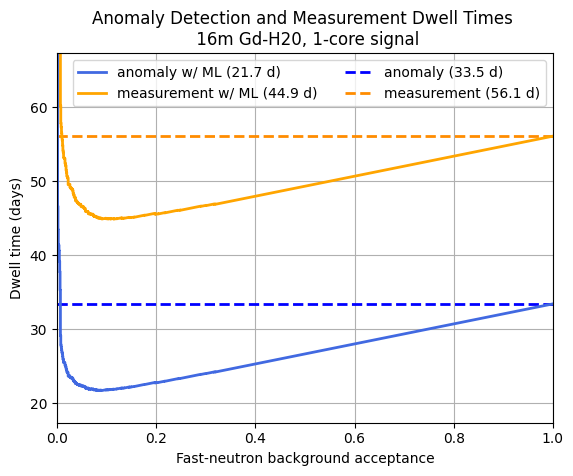

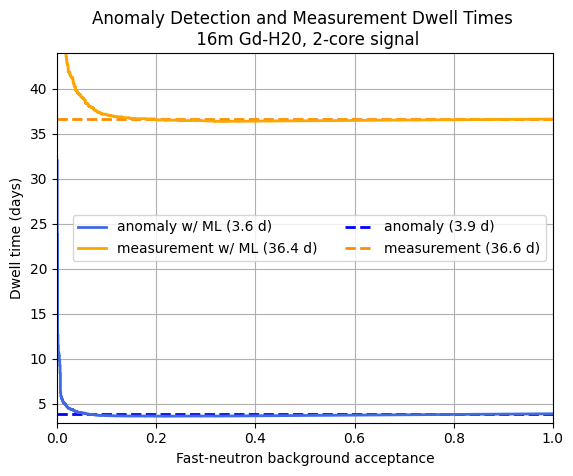

In [19]:
ml = ML_Evaluation(y_test, scores)
ml.draw_confmat(extra_title='(RNN into RF)')
tpr, fpr, thresholds = ml.draw_roc(extra_title='(RNN into RF)')

acceptances = dict(fpr=fpr, tpr=tpr)
# save_obj(acceptances, 'rates')
quick_analysis(acceptances)

## Trying more rigorous AdaBoost

In [36]:
rfpred = clf.predict_proba(new_train)[:,1]
rnnpred = rnn_out_train[:,0]
X = np.vstack([rfpred, rnnpred]).T

In [37]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)
bdt.fit(X, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=200)

In [38]:
rfpredtest = clf.predict_proba(new_test)[:,1].reshape(len(new_test),1)
rnnpredtest = rnn_out_test
Xtest = np.hstack([rfpredtest, rnnpredtest])
scores = bdt.predict_proba(Xtest)

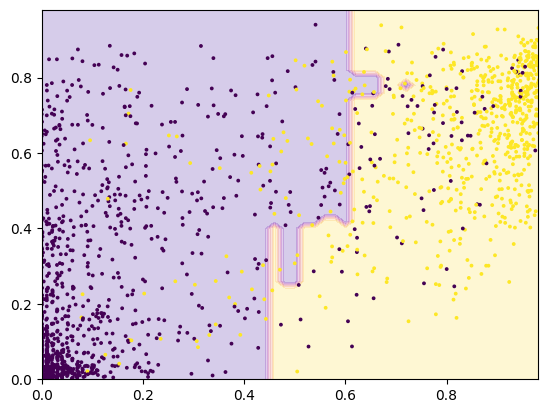

In [39]:
x_min, x_max = 0, 1
y_min, y_max = 0, 1
plot_step = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, 
                  cmap=plt.cm.plasma, alpha=0.2
                 )
plt.axis("tight")

plt.scatter(rfpredtest, rnnpredtest, c=y_test, cmap=plt.cm.viridis, s=3)
plt.show()

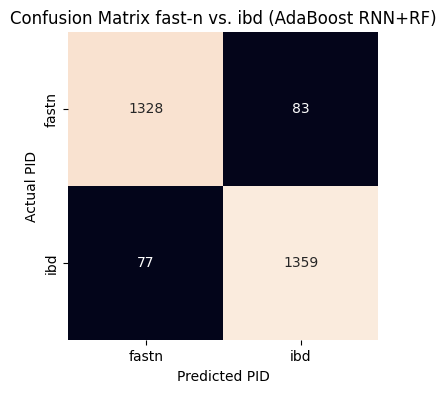

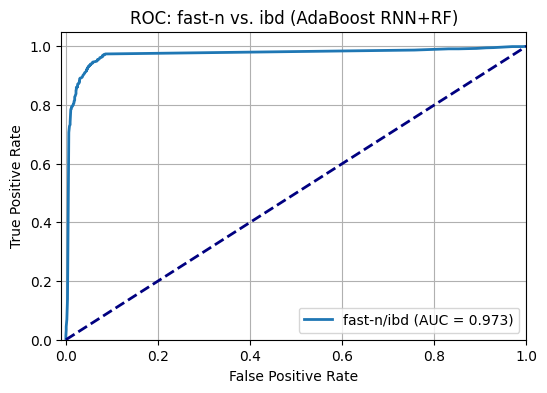

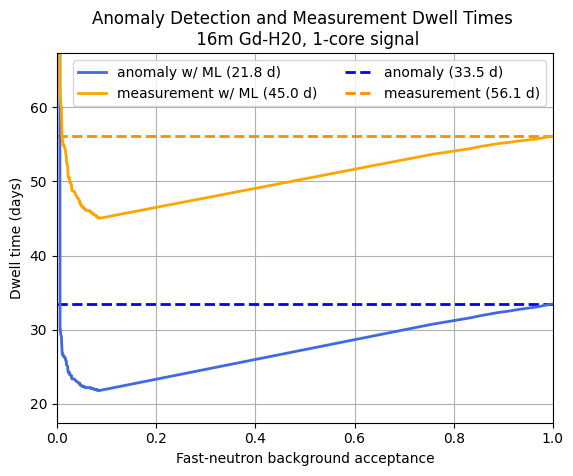

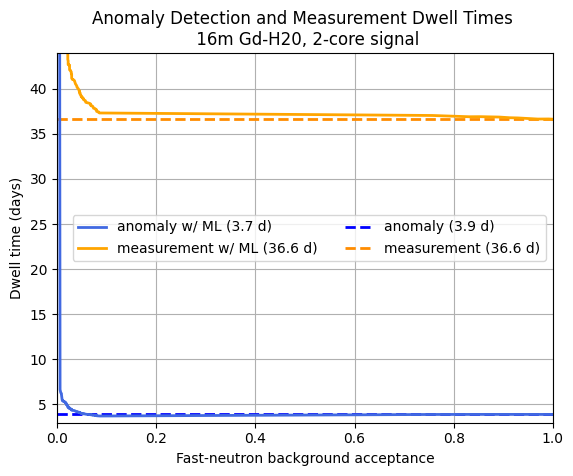

In [40]:
ml = ML_Evaluation(y_test, scores)
ml.draw_confmat(extra_title='(AdaBoost RNN+RF)')
tpr, fpr, thresholds = ml.draw_roc(extra_title='(AdaBoost RNN+RF)')

acceptances = dict(fpr=fpr, tpr=tpr)
# save_obj(acceptances, 'rates')
quick_analysis(acceptances)

### Simply taking the average as a comparison

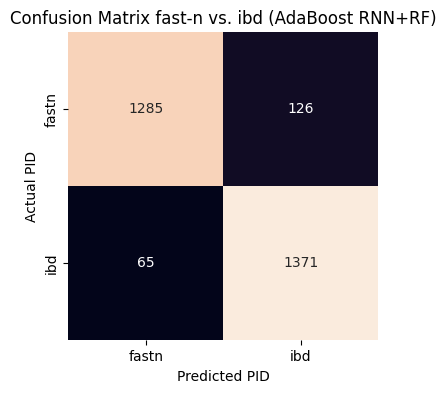

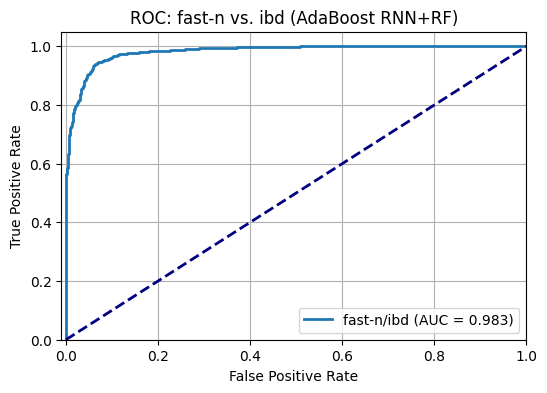

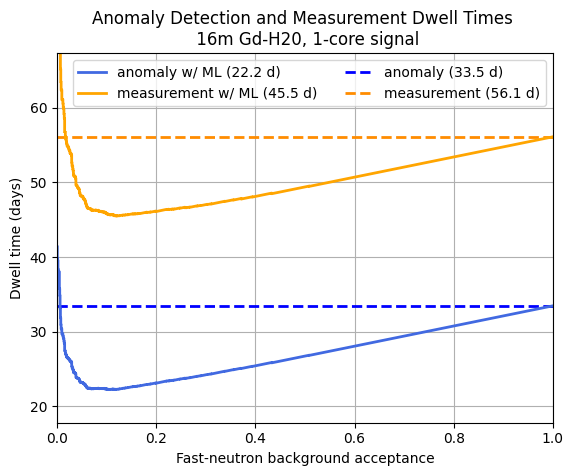

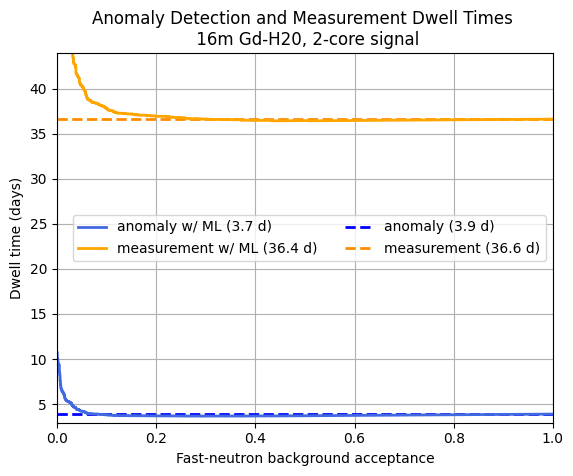

In [34]:
avgpred = (rfpredtest + rnnpredtest)/2
avgpred = avgpred.reshape(len(avgpred),1)
ml = ML_Evaluation(y_test, avgpred)
ml.draw_confmat(extra_title='(AdaBoost RNN+RF)')
tpr, fpr, thresholds = ml.draw_roc(extra_title='(AdaBoost RNN+RF)')

acceptances = dict(fpr=fpr, tpr=tpr)
# save_obj(acceptances, 'rates')
quick_analysis(acceptances)